In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from sklearn.naive_bayes import *
from sklearn.metrics import confusion_matrix

This notebook is an analysis of rat hippocampal recording data; the original dataset is posted <a href=https://crcns.org/data-sets/hc/hc-11/about-hc-11>here</a>.

## Unpacking the Data
This experiment contains **neural spiking** data and **rat position** data, saved into a `.mat` file. Because of the size of the data, Matlab saves it in a compressed format (hdf5) that must be read using the `h5py` module. We'll work with Cicero here, but if you'd like to explore more the Gatsby dataset is a different animal running on a linear track.

In [2]:
 f = h5py.File('Cicero_09102014_sessInfo.mat','r');
#f = h5py.File('Gatsby_08022013_sessInfo.mat','r');

This file contains a struct named `sessInfo` with fields `Position`, `Spikes`, and `Epochs`. `Position` and `spikes` contain the position of the rat as it runs along a track (called a maze), and the time of recorded spikes during this and other behaviors. `Epochs` gives the start and stop time of various behavioral assays (we'll ignore this for now and focus just on the maze-running experiment.)

### Position data
**`sessInfo.Positions`** gives the location of the rat while it runs on a (in this case circular) track. It has fields:
 * `MazeType`: the type of maze (ascii code, see conversion to string below)
 * `TwoDLocation`: the X- and Y- coordinates of the rat in the maze
 * `OneDLocation`: a 1D representation of the animal's position (ie how far around the circle it has run)
 * `TimeStamps`: the time at which the animal is at the given position (we'll use this to align to the spike data)

In [3]:
mazeType  = ''.join(chr(i) for i in np.squeeze(f['sessInfo']['Position']['MazeType'][()])); #converts ascii values to a string
time      = np.squeeze(f['sessInfo']['Position']['TimeStamps']);
pos2DRaw  = np.squeeze(f['sessInfo']['Position']['TwoDLocation']);
framerate = 1/np.mean(time[1:]-time[:-1]) #compute the framerate of position tracking as the mean difference between timestamps
T         = len(time);

The position data has some missing values (where the tracking failed). We can use `np.interp` to fill these in by linear interpolation. This works pretty well, although there are a few (rare) timepoints where the tracking does jump around.

In [4]:
pos2D    = np.copy(pos2DRaw);
x = lambda z: z.nonzero()[0]; # an anonymous helper function for interpolation
for i in range(0,2):
    nans = np.isnan(pos2D[i,:]);
    pos2D[i,nans] = np.interp(x(nans), x(~nans), pos2D[i,~nans]);

Here's what the position data looks like when we plot it:

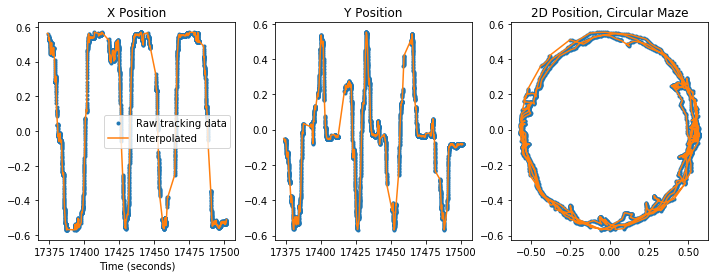

In [5]:
fig,ax = plt.subplots(1,3,figsize=(12,4));
inds = range(5000,10000);
ax[0].plot(time[inds],pos2DRaw[0,inds],'.',label='Raw tracking data');
ax[0].plot(time[inds],pos2D[0,inds],label='Interpolated');
ax[0].legend();
ax[0].set_title('X Position');
ax[0].set_xlabel('Time (seconds)')

ax[1].plot(time[inds],pos2DRaw[1,inds],'.',label='Raw tracking data');
ax[1].plot(time[inds],pos2D[1,inds],label='Interpolated');
ax[1].set_title('Y Position');
ax[0].set_xlabel('Time (seconds)')

ax[2].plot(pos2DRaw[0,inds],pos2DRaw[1,inds],'.',label='Raw tracking data');
ax[2].plot(pos2D[0,inds],pos2D[1,inds],label='Interpolated');
ax[2].set_title('2D Position, ' + mazeType);

Also to make life easier during decoding, we can try to decode the *phase* of the rat's trajectory around the maze, rather than its (x,y) position. This is given by:

In [6]:
linearPos = np.arctan2(pos2D[0,:-1],pos2D[1,:-1]); # for circular mazes

### Spiking data
`sessInfo.Spikes` contains the recorded neural spiking from the experiment, which includes both the maze-running session as well as several other behaviors we won't be considering here. It has the following fields:
 * `SpikeTimes`: the time (in seconds) at which each spike occurs
 * `SpikeIDs`: which recorded neuron fired each spike in `SpikeTimes`- eg, the tenth spike recorded happened at time `SpikeTimes[9]`, and was fired by neuron `SpikeIDs[9]`.
 * `PyrIDs`: the ID numbers of recorded neurons that are hypothesized (based on spike waveforms) to be pyramidal cells
 * `IntIDs`: the ID numbers of recorded numbers that are hypothesized to be inhibitory interneurons

In [7]:
spTimes = f['sessInfo']['Spikes']['SpikeTimes'][0];
spIDs   = f['sessInfo']['Spikes']['SpikeIDs'][0];
cells   = np.unique(spIDs);
N       = len(cells);

The original dataset contains spikes from a series of experiments; we only want to consider spikes that happened while the mouse was running on the maze, so we'll extract those out:

In [8]:
mazeTimes    = np.logical_and(spTimes>=min(time), spTimes<=max(time));
mazeSpikes   = spTimes[mazeTimes];
mazeIDs      = spIDs[mazeTimes];

Now, we're going to convert the data in `mazeSpikes` and `mazeIDs` into a *spike raster*. This is similar to the vector of spikes we constructed in module 1 (spike-triggered averaging), but now the spikes come from multiple neurons, so instead of a vector we create an $N$ (neurons) by $T$ (time) *matrix* of spikes.

In [9]:
raster = np.zeros((N+1,T-1));
for ind,i in enumerate(cells.T):
    raster[ind,:],_ = np.histogram(mazeSpikes[mazeIDs==i],time);

Here's what that spike raster looks like:

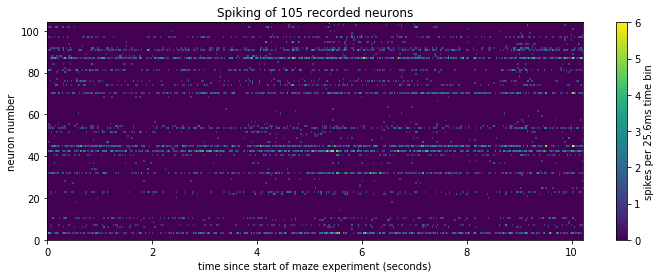

In [10]:
plt.figure(figsize=(12,4));
inds = range(0,400);
plt.imshow(raster[:,inds],extent=[time[inds[0]]-time[0],time[inds[-1]]-time[0],0,N-1],aspect='auto');
plt.title('Spiking of ' + str(N) + ' recorded neurons');
plt.xlabel('time since start of maze experiment (seconds)');
plt.ylabel('neuron number');
h=plt.colorbar();
h.set_label('spikes per ' + "{:.1f}".format(1/framerate*1000) + 'ms time bin');

That's the data unpacked! So **at time $t$, the rat is at position `pos2d[:,t]` (or linearlized position `linearPos[t]`), and the spiking activity of the N recorded neurons is given by `raster[:,t]`**.

Before going to the next step, we'll adjust `time` so the maze run starts at time 0 instead of 17,375, and then clear some variables that are no longer needed to free up memory.

In [11]:
time = time - time[0];
del f, spTimes, spIDs;

We're also going to define a helper function that we can use to smooth our spike raster with a moving average (you may find this useful for decoding.)

In [12]:
def smooth(a,WSZ):
    # a: NumPy 1-D or 2-D array containing the data to be smoothed (row-wise)
    # WSZ: smoothing window size needs, which must be odd number
    aSm = np.zeros(a.shape);
    if(len(a.shape)==1):
        out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ;
        r = np.arange(1,WSZ-1,2);
        start = np.cumsum(a[:WSZ-1])[::2]/r;
        stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1];
        aSm = np.concatenate((  start , out0, stop  ));
    else:
        for i in range(0,a.shape[0]):
            out0 = np.convolve(a[i,:],np.ones(WSZ,dtype=int),'valid')/WSZ;
            r = np.arange(1,WSZ-1,2);
            start = np.cumsum(a[i,:WSZ-1])[::2]/r;
            stop = (np.cumsum(a[i,:-WSZ:-1])[::2]/r)[::-1];
            aSm[i,:] = np.concatenate((  start , out0, stop  ));
    return aSm;

## Decoding position from single neurons
Given neural data $y$ from a rat at position $x$, we will start by computing the **prior** $P(x)$and the **likelihood** $P(y|x)$ for a handful of example neurons. You'll want to discretize your representation of the rat's position into a handful of bins (I found 6 worked well.)

if you'd like, you can also plot a neuron's spikes superimposed over its position. If these were place cells, you'd see nice concentration of spiking at a certain location in the maze. (Unfortunately for us, they're not really that clean! But that doesn't mean we can't decode the rat's position from them.)

ML accuracy: 4.97%
MAP accuracy: 65.69%
Chance accuracy: 16.67%


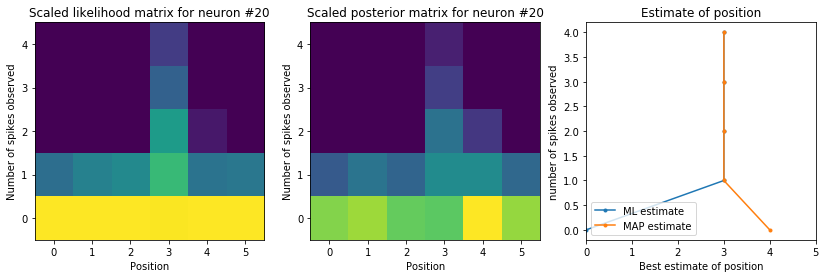

In [163]:
# convert 1D positions to discretized categories
nBinsY  = 6;
digitizedPos = np.digitize(linearPos,np.linspace(min(linearPos),max(linearPos)+0.001,nBinsY+1)) - 1;
posBins = np.arange(0,nBinsY);

# choose an example cell to use for decoding, and then discretize spiking
cellnum = 20;
nBinsX  = 5;
spikes  = np.squeeze(raster[cellnum,:]);
digitizedSpikes = np.digitize(spikes,np.linspace(min(spikes),max(spikes)+0.001,nBinsX+1)) - 1;
spikeBins = np.arange(0,nBinsX+1);

# compute the prior, p(position):
posBinned,_ = np.histogram(digitizedPos[indsTrain],np.arange(0,nBinsY+1));
posBinned   += 1; # we'll add 1 to each bin so the prior never assigns a probability of 0 to any location.
prior       = posBinned/sum(posBinned);

# compute the likelihood p(spiking|position) for each position:
# first find all times within indsTrain where the animal was in position i,
# then use logical indexing to compute the histogram of spike counts for those times.
likelihood = np.zeros((nBinsY,nBinsX));
for ind in range(0,nBinsY):
    hits = digitizedPos[indsTrain]==ind;
    likelihood[ind,:],_ = np.histogram(digitizedSpikes[indsTrain[hits]],spikeBins);
    likelihood[ind,:]   /= sum(likelihood[ind,:]);

# and now compute the posterior, p(position|spiking), from the likelihood and the prior:
posterior = np.multiply(likelihood.T,prior).T;

# the maximum likelihood estimate of the animal's position = which position has highest probability in the likelihood, 
# given the observed number of spikes.
# the maximum a-priori (MAP) estimate is the same, but computed from the posterior.
ML           = np.argmax(likelihood,0);
MAP          = np.argmax(posterior,0);

# now let's predict the rat's position at the timepoints in indsTest, using the maximum likelihood and MAP estimates:
MLestimate   = ML[digitizedSpikes[indsTest]];
MAPestimate  = MAP[digitizedSpikes[indsTest]];
groundTruth  = Y[indsTest];


print('ML accuracy: %0.2f%%' % (100 * np.mean(MLestimate==groundTruth)))
print('MAP accuracy: %0.2f%%' % (100 * np.mean(MAPestimate==groundTruth)))
print('Chance accuracy: %0.2f%%' % (100 * 1/nBinsY))

fig,ax = plt.subplots(1,3,figsize=(14,4));
ax[0].imshow(np.log(likelihood.T+0.0001),aspect='auto',origin='lower');
ax[0].set_title('Scaled likelihood matrix for neuron #' + str(cellnum))
ax[0].set_ylabel('Number of spikes observed');
ax[0].set_xlabel('Position');

ax[1].imshow(np.log(posterior.T+.00001),aspect='auto',origin='lower');
ax[1].set_title('Scaled posterior matrix for neuron #' + str(cellnum))
ax[1].set_ylabel('Number of spikes observed');
ax[1].set_xlabel('Position');

ax[2].plot(ML,np.arange(0,5),'.-',label='ML estimate');
ax[2].plot(MAP,np.arange(0,5),'.-',label='MAP estimate');
ax[2].set_ylabel('number of spikes observed');
ax[2].set_title('Estimate of position');
ax[2].set_xlabel('Best estimate of position');
ax[2].set_xlim((0,5));
ax[2].legend(loc=3);

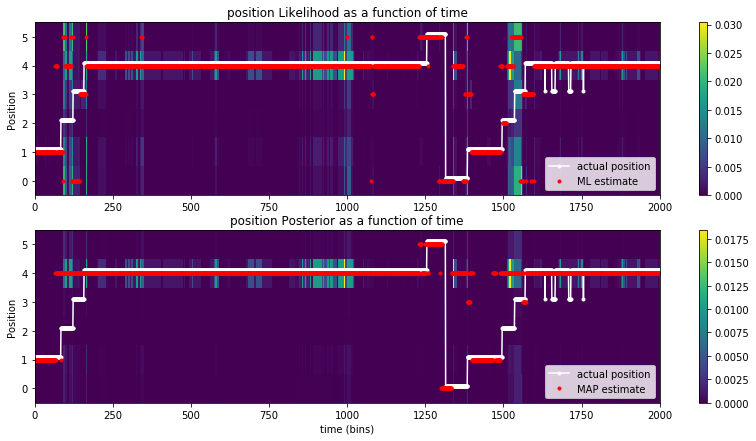

In [77]:
nBins  = 6; # number of position categories to use
nXBins = 4; # number of spiking categories to use
binInds = np.arange(0,nBins+1);
XbinInds = np.arange(0,nXBins+1);

sm     = 25; # smooth the spiking data by taking a sm-frame moving average
nCells = 50;
 
# specify training and test sets
indsTrain = np.arange(0,60000);
indsTest  = np.arange(60001,90000);

bins     = np.linspace(min(linearPos)-.001,max(linearPos)+.001,nBins+1);
Y        = np.digitize(linearPos,bins) - 1;
posRange = np.arange(0,nBins);


likelihood = np.zeros((nCells,nBins,nXBins));
posterior  = np.zeros((nCells,nBins,nXBins));
for cellnum in range(0,nCells):
    
    # discretize spiking for this cell
    X     = smooth(np.squeeze(raster[cellnum,:]),sm);
    Xbins = np.linspace(min(X),max(X)+.001,nXBins+1);
    X     = np.digitize(X,Xbins)-1;

    # compute the prior
    YBinned,_ = np.histogram(Y[indsTrain],binInds);
    prior = YBinned/sum(YBinned) + np.finfo(float).eps;

    # compute the likelihood matrix p(spike|position) over all values of position:
    for ind in posRange:
        likelihood[cellnum,ind,:],_ = np.histogram(X[indsTrain[Y[indsTrain]==ind]],XbinInds);
        likelihood[cellnum,ind,:]   = likelihood[cellnum,ind,:]/sum(likelihood[cellnum,ind,:]); #normalize so sum is 1

# now, let's do some prediction using the whole population

Tmax = 2000; #I'm just going to predict over the first 2000 timepoints of the test set
groundTruth       = Y[indsTest];
runningLikelihood = np.ones((Tmax,nBins));
runningPosterior  = np.ones((Tmax,nBins));
popML             = np.zeros((Tmax,1));
popMAP            = np.zeros((Tmax,1));
   
for cellnum in range(0,nCells):
    X         = smooth(np.squeeze(raster[cellnum,:]),sm);
    Xbins     = np.linspace(min(X),max(X)+.001,nXBins);
    X         = np.digitize(X,Xbins)-1;
        
    for t in range(0,Tmax):
        obsSpikes = X[indsTest[t]];
        runningLikelihood[t,:] = np.multiply(runningLikelihood[t,:],np.squeeze(likelihood[cellnum,:,obsSpikes]));


# now compute the posterior at each timepoint t by multiplying the running likelihood by the prior
for t in range(0,Tmax):
    runningPosterior[t,:] = np.multiply(runningLikelihood[t,:],prior);
    popMAP[t] = np.argmax(np.squeeze(runningPosterior[t,:]));
    popML[t] = np.argmax(np.squeeze(runningLikelihood[t,:]));


fig,ax = plt.subplots(2,1,figsize=(14,7));
h = ax[0].imshow(runningLikelihood.T,aspect='auto',origin='lower');
ax[0].set_ylabel('Position');
ax[0].set_title('position Likelihood as a function of time')
ax[0].plot(groundTruth[:Tmax]+.1,'w.-',label='actual position');
ax[0].plot(popML,'r.',label='ML estimate');
fig.colorbar(h,ax=ax[0]);
ax[0].legend(loc=4);

h = ax[1].imshow(runningPosterior.T,aspect='auto',origin='lower');
ax[1].set_xlabel('time (bins)');
ax[1].set_ylabel('Position');
ax[1].set_title('position Posterior as a function of time')
ax[1].plot(groundTruth[:Tmax]+.1,'w.-',label='actual position');
ax[1].plot(popMAP,'r.',label='MAP estimate');
fig.colorbar(h,ax=ax[1]);
ax[1].legend(loc=4);

Accuracy: 64.98%
Chance accuracy: 16.67%


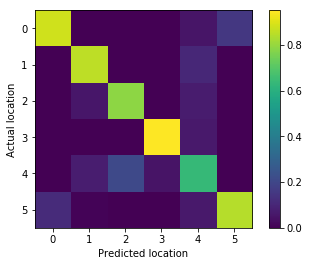

In [76]:
nBins  = 6;
bins   = np.linspace(min(linearPos),max(linearPos)+0.001,nBins+1);
Y      = np.digitize(linearPos,bins);

sm = 9; # smooth the spiking data with a moving average
X  = smooth(raster,sm).T;

indsTrain = np.arange(0,80000);
indsTest = np.arange(80001,90000);

mdl         = MultinomialNB();
myModel     = mdl.fit(X[indsTrain,:], Y[indsTrain]);
estimate    = myModel.predict(X[indsTest,:]);
groundTruth = Y[indsTest];

print('Accuracy: %0.2f%%' % (100*np.mean(estimate==groundTruth)))
print('Chance accuracy: %0.2f%%' % (100*1/(len(bins)-1)))

M = confusion_matrix(groundTruth,estimate);
plt.imshow(np.divide(M,sum(M,0)+np.finfo(float).eps));
plt.xlabel('Predicted location');
plt.ylabel('Actual location');
plt.colorbar();

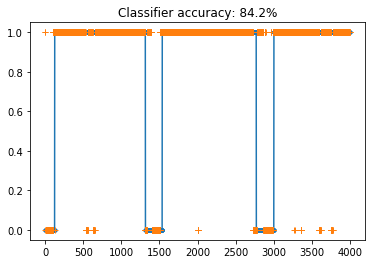

In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis();
Y = linearPos>0; # convert linear position to something binary
sm = 25;

indsTrain = np.arange(0,60000);
indsTest = np.arange(60001,90000);

Y = linearPos[indsTrain]>0;
X = smooth(raster[:40,indsTrain],sm);
clf.fit(X.T, Y);

Ytest = linearPos[indsTest]>0;
Xtest = smooth(raster[:40,indsTest],sm);
est = clf.predict(Xtest.T);

plt.plot(Ytest[:4000],'.-');
plt.plot(est[:4000],'+');

MSE =  ((Ytest.astype(int) - est)**2).mean(axis=0);
plt.title('Classifier accuracy: %02.1f%%' % (100*(1-MSE)));